In [129]:
import folium
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import json
import googlemaps
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
import matplotlib.pyplot as plt
%matplotlib inline
import platform
import seaborn as sns
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family = 'AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system. sorry~~~')

import pandas_datareader.data as web
from fbprophet import Prophet
from datetime import datetime
from pandas_datareader import data
from konlpy.tag import Kkma
from konlpy.tag import Hannanum
from bs4 import BeautifulSoup
from urllib.request import urlopen
import urllib
import time 
from tqdm import tqdm_notebook
from wordcloud import WordCloud, STOPWORDS
import numpy as np
from PIL import Image
import nltk
from konlpy.corpus import kobill

In [130]:
data = pd.read_csv('../data/country_drin.csv')

In [131]:
serve_list = ['beer_servings','spirit_servings','wine_servings']

# 1.피처간의 상관간계 분석

C:\Users\A\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


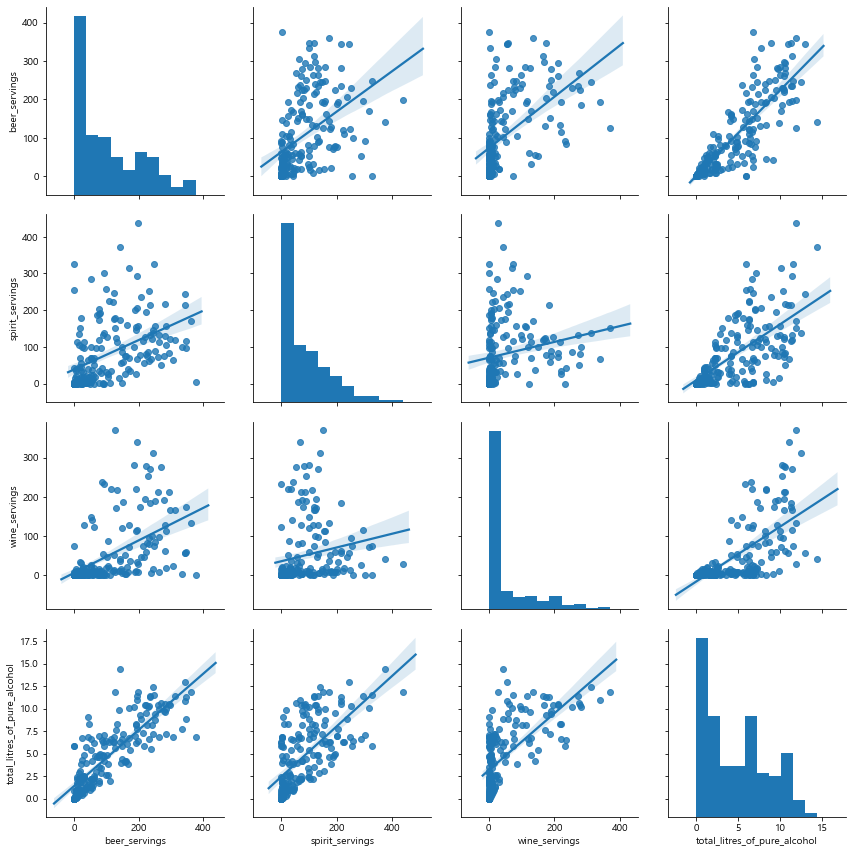

In [132]:
sns.pairplot(data, vars = ['beer_servings', 'spirit_servings','wine_servings', 'total_litres_of_pure_alcohol'], kind = 'reg', size = 3)
plt.show()

# 2. 가장 많이 주문한 item은?

In [133]:
data1 = pd.melt(data, id_vars = ['country','total_litres_of_pure_alcohol',
                                 'continent'])

data1[data1['value'] == data1['value'].max()]

,country,total_litres_of_pure_alcohol,continent,variable,value
261,Grenada,11.9,NaN,spirit_servings,438


# 3. continent 컬럼의 결측 데이터 처리 

In [134]:
data['continent'] = data['continent'].fillna('OT')
data[data['continent'].isnull()]

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol,continent


# 4. 파이차트로 시각화 해보세요. - 평균치 기준

In [222]:
data_cont = data.iloc[:,1:]
data_cont_group = data_cont.groupby('continent').mean()
data_cont_group

,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol
continent,,,,
AF,61.471698,16.339623,16.264151,3.007547
AS,37.045455,60.840909,9.068182,2.170455
EU,193.777778,132.555556,142.222222,8.617778
OC,89.687500,58.437500,35.625000,3.381250
OT,145.434783,165.739130,24.521739,5.995652
SA,175.083333,114.750000,62.416667,6.308333


Text(0, 0.5, '')

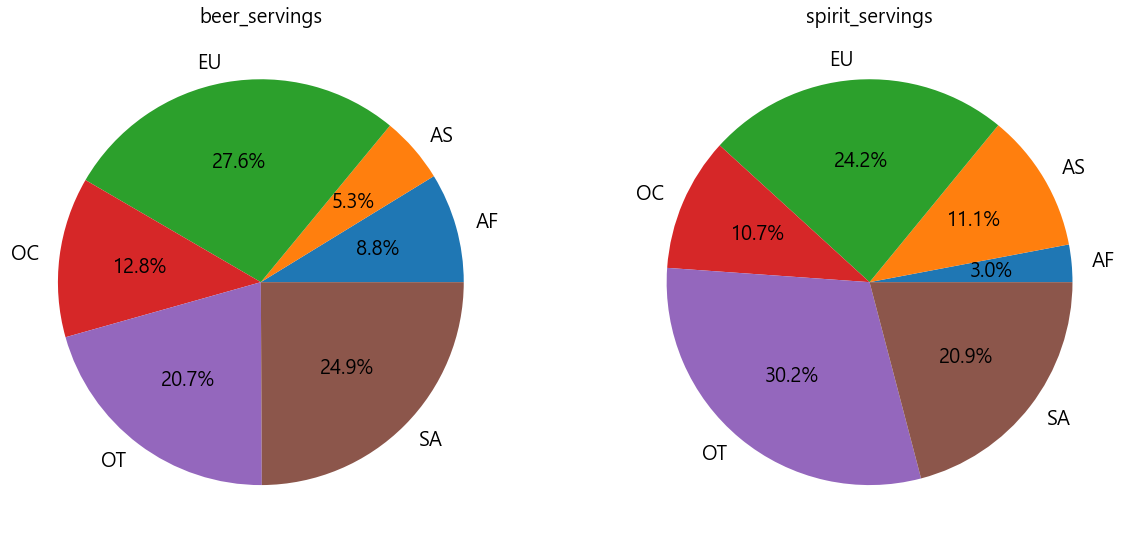

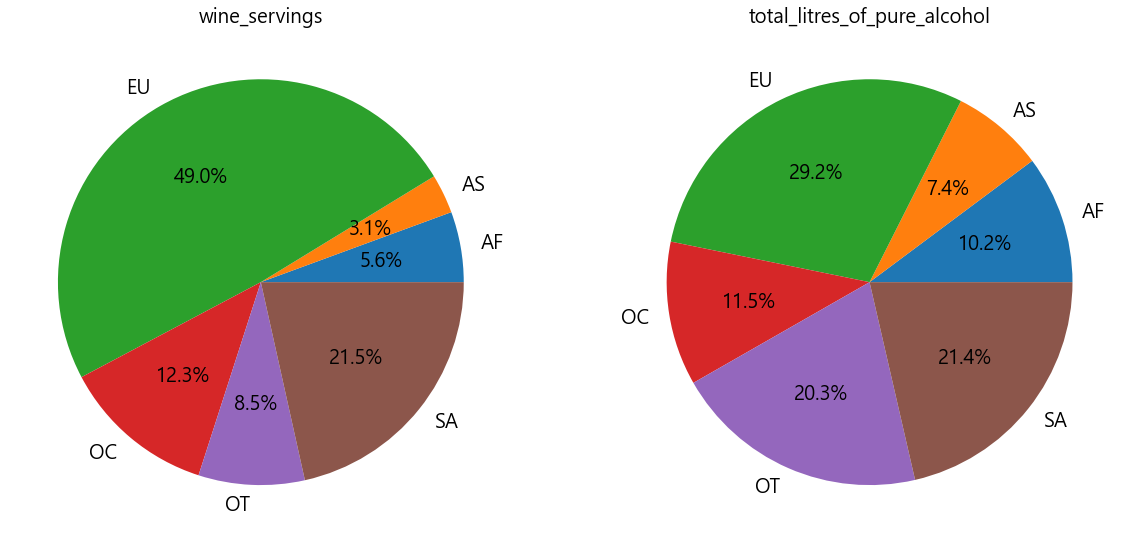

In [237]:
f, ax = plt.subplots(1,2, figsize = (20,20))
f1, ax1 = plt.subplots(1,2, figsize = (20,20))

data_cont_group['beer_servings'].plot.pie(ax = ax[0], autopct = '%1.1f%%',
                                    labels= data_cont_group.index,
                           fontsize = 20)
ax[0].set_title('beer_servings', size =  20)
ax[0].set_ylabel('')

data_cont_group['spirit_servings'].plot.pie(ax = ax[1], autopct = '%1.1f%%',
                                    labels= data_cont_group.index,
                           fontsize = 20)
ax[1].set_title('spirit_servings', size =  20)
ax[1].set_ylabel('')


data_cont_group['wine_servings'].plot.pie(ax = ax1[0], autopct = '%1.1f%%',
                                    labels= data_cont_group.index,
                           fontsize = 20)
ax1[0].set_title('wine_servings', size =  20)
ax1[0].set_ylabel('')


data_cont_group['total_litres_of_pure_alcohol'].plot.pie(ax = ax1[1], autopct = '%1.1f%%',
                                    labels= data_cont_group.index,
                           fontsize = 20)
ax1[1].set_title('total_litres_of_pure_alcohol', size =  20)
ax1[1].set_ylabel('')



# 5. 대륙별 wine의 통계 계산

In [224]:
print('대륙별 wine 소비 최대량\n',data_cont.groupby('continent').wine_servings.max(),'\n\n')

print('대륙별 wine 소비 최소량\n',data_cont.groupby('continent').wine_servings.min(),'\n\n')

print('대륙별 wine 소비 평균\n',data_cont.groupby('continent').wine_servings.mean(),'\n\n')

print('대륙별 wine 소비 합계\n',data_cont.groupby('continent').wine_servings.sum(),'\n\n')


대륙별 wine 소비 최대량
 continent
AF    233
AS    123
EU    370
OC    212
OT    100
SA    221
Name: wine_servings, dtype: int64 


대륙별 wine 소비 최소량
 continent
AF    0
AS    0
EU    0
OC    0
OT    1
SA    1
Name: wine_servings, dtype: int64 


대륙별 wine 소비 평균
 continent
AF     16.264151
AS      9.068182
EU    142.222222
OC     35.625000
OT     24.521739
SA     62.416667
Name: wine_servings, dtype: float64 


대륙별 wine 소비 합계
 continent
AF     862
AS     399
EU    6400
OC     570
OT     564
SA     749
Name: wine_servings, dtype: int64 




# 6. 전체 평균보다 많은 알코올을 섭취한 대륙은?

In [249]:
data_cont_tot = pd.DataFrame(data_cont.groupby('continent').total_litres_of_pure_alcohol.mean(), columns=['total_litres_of_pure_alcohol'])
print('전체 평균 보다 많은 알코올을 섭취한 대륙은?')
print('전체 평균 : %f'%(data_cont_tot['total_litres_of_pure_alcohol'].mean()))
for i in data_cont_tot.index:
    if data_cont_tot.loc[i,'total_litres_of_pure_alcohol'] > data_cont_tot['total_litres_of_pure_alcohol'].mean():
        print('대륙 이름 : %s, 총 알코올  소비량 : %f'%(i, data_cont_tot.loc[i,'total_litres_of_pure_alcohol']))

전체 평균 보다 많은 알코올을 섭취한 대륙은?
전체 평균 : 4.913503
대륙 이름 : EU, 총 알코올  소비량 : 8.617778
대륙 이름 : OT, 총 알코올  소비량 : 5.995652
대륙 이름 : SA, 총 알코올  소비량 : 6.308333


# 7. 전체 평균보다 많은 와인을 섭취한 대륙은?

In [250]:
data_wine_cont = pd.DataFrame(data_cont.groupby('continent').wine_servings.mean(), columns=['wine_servings'])
print('전체 평균 보다 많은 와인을 섭취한 대륙은?')
print('전체 평균 : %f'%(data_wine_cont['wine_servings'].mean()))
for i in data_wine_cont.index:
    if data_wine_cont.loc[i,'wine_servings'] > data_wine_cont['wine_servings'].mean():
        print('대륙 이름 : %s, 와인 소비량 : %f'%(i, data_wine_cont.loc[i,'wine_servings']))

전체 평균 보다 많은 와인을 섭취한 대륙은?
전체 평균 : 48.352993
대륙 이름 : EU, 와인 소비량 : 142.222222
대륙 이름 : SA, 와인 소비량 : 62.416667


# 8. 대륙별 알코올 소비량을 그래프로 나타내 보세요.

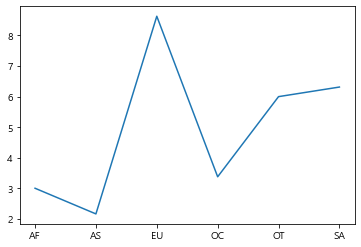

In [209]:
plt.plot(data_cont)

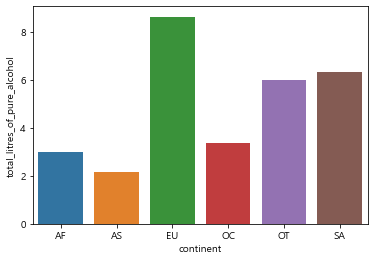

In [210]:
sns.barplot(x=data_cont.index, y="total_litres_of_pure_alcohol", data=data_cont)

## 9. 한국은 술을 얼마나 독하게 마시는가?


In [218]:
data_cont.groupby('continent').mean()

In [239]:
data[data['country'] =='South Korea']

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol,continent
138,South Korea,140,16,9,9.8,AS


In [245]:
data_sort = data.sort_values('total_litres_of_pure_alcohol', ascending=False)

In [248]:
data_sort = data_sort.reset_index()
del data_sort['index']

In [252]:
data_sort[data_sort['country'] =='South Korea']

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol,continent
27,South Korea,140,16,9,9.8,AS


In [253]:
data_sort_30 = data_sort.iloc[:30]

In [259]:
data_sort_30.tail()

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol,continent
25,Finland,263,133,97,10.0,EU
26,Spain,284,157,112,10.0,EU
27,South Korea,140,16,9,9.8,AS
28,Austria,279,75,191,9.7,EU
29,Serbia,283,131,127,9.6,EU


(5.0, 15.0)

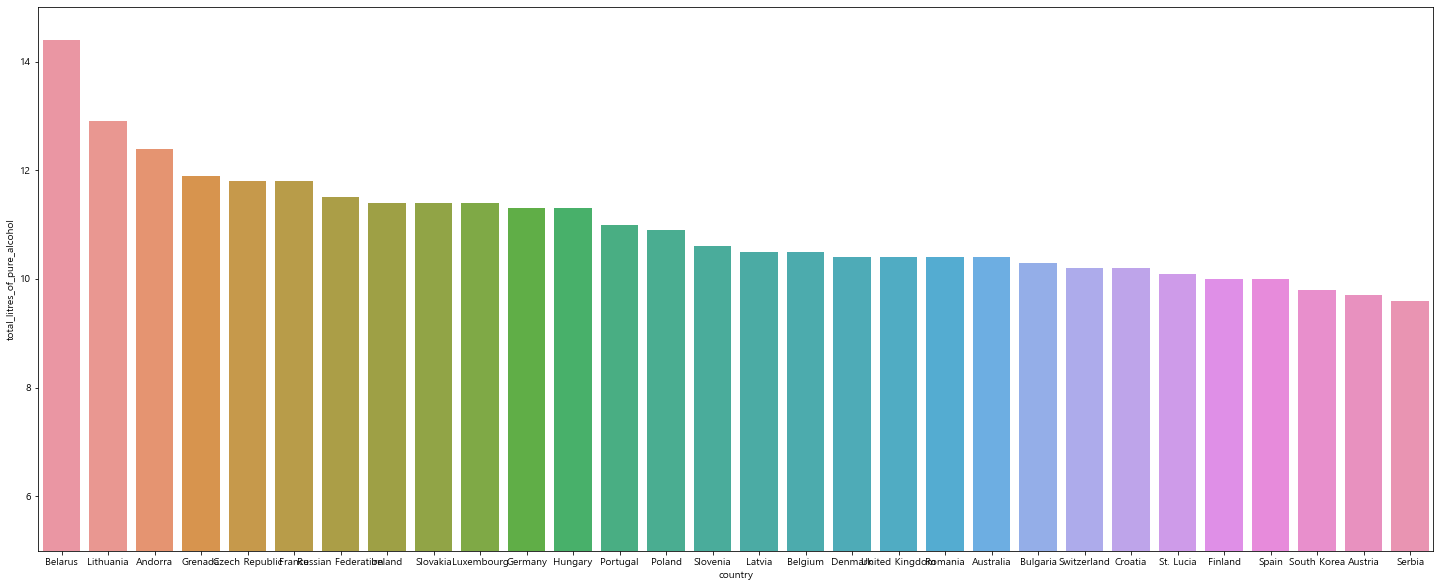

In [261]:
ax = plt.subplots(figsize = (25, 10))
ax = sns.barplot(x='country', y="total_litres_of_pure_alcohol", data=data_sort_30)
ax.set_ylim(5, 15)